In [43]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, random
import importlib
import numpy as np
from sklearn.metrics import make_scorer, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Class Import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../.."))) #Allow for imports from src
from src.models import Gradient_Boosting_Optimization
importlib.reload(Gradient_Boosting_Optimization) #Ensures file is uptodate!
from src.models.Gradient_Boosting_Optimization import Gradient_Boosting_Optimization

#Set Seed
os.environ["PYTHONHASHSEED"] = "1945"
random.seed(1945)
np.random.seed(1945)

In [44]:
#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
df.shape #Test

(1174, 21)

In [45]:
#Drop unecessary/redundent features
df = df.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df.reset_index(drop=True).head(3)

,Number of Ships,Number of Escort Ships,Number of Stragglers,Total Tons of Convoy,Overall Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range
0,5.0,2.0,0.0,22877.0,0.0,6.0,0.400000,3.0,9.0,1939.0,0.0,12.190200
1,5.0,2.0,0.0,22967.0,0.0,6.0,0.400000,5.0,9.0,1939.0,0.0,12.190200
2,7.0,4.0,0.0,21293.0,0.0,6.0,0.571429,5.0,9.0,1939.0,0.0,14.434062


In [46]:
#Convert Overall Sink Percentage to binary 1( High)
df['Risk'] = (df['Overall Sink Percentage'] > 0).astype(int) 
#Risk is binary based off whether a ship was sunk while in a convoy:  (0 = No Ships Sunk, 1 = At Least One Ship Sunk)
X = np.array(df.drop(columns=['Overall Sink Percentage', 'Risk'])) #Remove Overall Sink Percentage as it leaks data
y = df['Risk'].values #Prediction value

In [47]:
#Feature Names for later feature analysis:
feature_names = list(df)
feature_names[:-1]

['Number of Ships',
 'Number of Escort Ships',
 'Number of Stragglers',
 'Total Tons of Convoy',
 'Overall Sink Percentage',
 'Avg Number of U-Boats in Atlantic',
 'Escort Ratio',
 'Time At Sea (Days)',
 'Month',
 'Year',
 'Previous Month Avg Sink %',
 'Approx. Sighting Range']


Best Hyperparameters Found:
{'learning_rate': 0.12, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.7}
Best Cross-Validation Score: 0.4677
Applied decision threshold: 0.3930 (F-beta: 0.9930)

GradientBoostingClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       185
           1       0.62      0.58      0.60        50

    accuracy                           0.83       235
   macro avg       0.75      0.74      0.75       235
weighted avg       0.83      0.83      0.83       235


ROC AUC Score: 0.8248
Matthews Correlation Coefficient (MCC): 0.4939
Balanced Accuracy: 0.7414
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          167           18
Actual 1           21           29
Recall (positive=1): 0.5800
F2 Score: 0.5870
False Negatives: 21

GradientBoostingClassifier Plots:



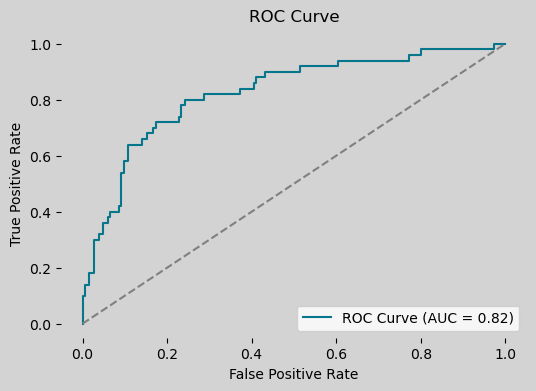

GradientBoostingClassifier Confusion Matrix Plot:


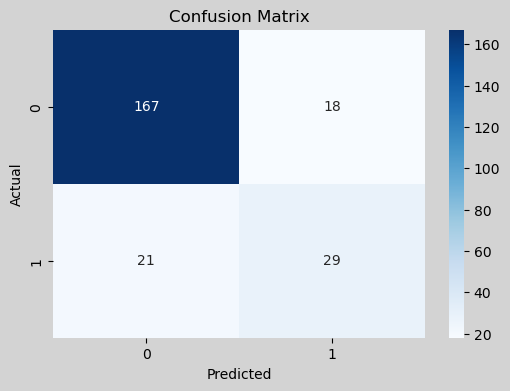

GradientBoostingClassifier Feature Importance Plot:


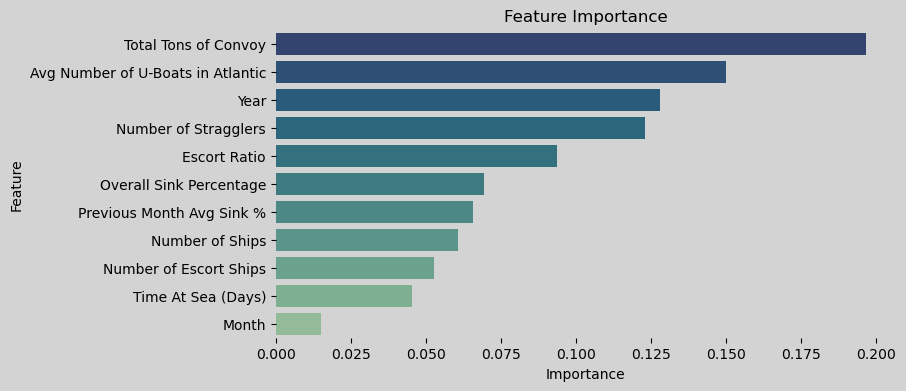

In [51]:
#Main Optimized Model:
#Gradient_Boosting_Optimization, grid-search & F2 threshold optimization
gb_grid = Gradient_Boosting_Optimization(
    model=GradientBoostingClassifier(random_state=1945),
    feature_names=feature_names,
    parameter_grid = {
        "learning_rate": [0.05, 0.08, 0.1, 0.12, 0.15],
        "n_estimators": [300, 320, 340, 360, 380],
        "max_depth": [3, 4, 5],
        "min_samples_leaf": [1, 2, 3, 5],
        "min_samples_split": [2, 3, 5],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "max_features": ["sqrt", "log2", None],},
    cv_folds=5,
    positive_label=1,
    optimize_scoring="recall",
    auto_calibrate_threshold=True,
    threshold_beta=2.0)

gb_grid.train_test_split(X, y, train_size=0.8, random_state=1945)
gb_grid.optimize()
gb_grid_results = gb_grid.evaluate(show_plots=True, save_plots=True)


In [49]:
#Manual Threshold Comparison using gb_grid: 
thresholds = np.arange(0, 1.05, 0.05) 
thresholds = thresholds.tolist() 
rows = []

for t in thresholds:
    gb_grid.set_decision_threshold(t)
    res = gb_grid.evaluate(show_plots=False, print_results=False)
    rows.append({
        "threshold": t,
        "recall": res["recall"],
        "precision": res["classification_report"]["1"]["precision"],
        "false_negatives": res["false_negatives"],
        "accuracy": res["classification_report"]["accuracy"],
        "f1-scores": res["classification_report"]["macro avg"]["f1-score"]
        })
gb_grid.set_decision_threshold(None) 
threshold_results = pd.DataFrame(rows)
threshold_results

/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

,threshold,recall,precision,false_negatives,accuracy,f1-scores
0,0.00,1.00,0.212766,0,0.212766,0.175439
1,0.05,0.86,0.361345,7,0.646809,0.616564
2,0.10,0.80,0.449438,10,0.748936,0.698646
3,0.15,0.72,0.480000,14,0.774468,0.711188
4,0.20,0.68,0.523077,16,0.800000,0.729455
5,0.25,0.64,0.551724,18,0.812766,0.735523
6,0.30,0.64,0.592593,18,0.829787,0.753047
7,0.35,0.60,0.600000,20,0.829787,0.745946
8,0.40,0.54,0.600000,23,0.825532,0.729544
9,0.45,0.46,0.575000,27,0.812766,0.697661


In [50]:
res

{'model_name': 'GradientBoostingClassifier',
 'classification_report': {'0': {'precision': 0.7872340425531915,
   'recall': 1.0,
   'f1-score': 0.8809523809523809,
   'support': 185.0},
  '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 50.0},
  'accuracy': 0.7872340425531915,
  'macro avg': {'precision': 0.39361702127659576,
   'recall': 0.5,
   'f1-score': 0.44047619047619047,
   'support': 235.0},
  'weighted avg': {'precision': 0.6197374377546401,
   'recall': 0.7872340425531915,
   'f1-score': 0.6935157041540021,
   'support': 235.0}},
 'confusion_matrix': array([[185,   0],
        [ 50,   0]]),
 'roc_auc': 0.8247567567567567,
 'mcc': 0.0,
 'balanced_accuracy': 0.5,
 'recall': 0.0,
 'f2_score': 0.0,
 'decision_threshold': 1.0,
 'threshold_metric': 0.9930486593841087,
 'false_negatives': 50}